In [32]:
%pylab inline
import uuid
import base64
import cPickle as pickle
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')
import os

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# we get this by running:
#  python flops_benchmark.py  --workers 3000 --outfile flops_benchmark.2.pickle  --loopcount=20 --matn=4096

In [50]:

benchmark_data = pickle.load(open("flops_benchmark.2.pickle", 'r'))

callset_id = benchmark_data['callset_id']
est_total_flops = benchmark_data['est_flop']

In [51]:

invoke_df = pd.DataFrame(benchmark_data['results'])
results_df = pd.DataFrame(benchmark_data['run_statuses'])


In [52]:
results_df = pd.concat([results_df, invoke_df], axis=1)

In [53]:
results_df['runtime_cached'].value_counts()

True     1965
False    1035
Name: runtime_cached, dtype: int64

In [54]:
JOB_GFLOPS = est_total_flops /1e9 /total_jobs

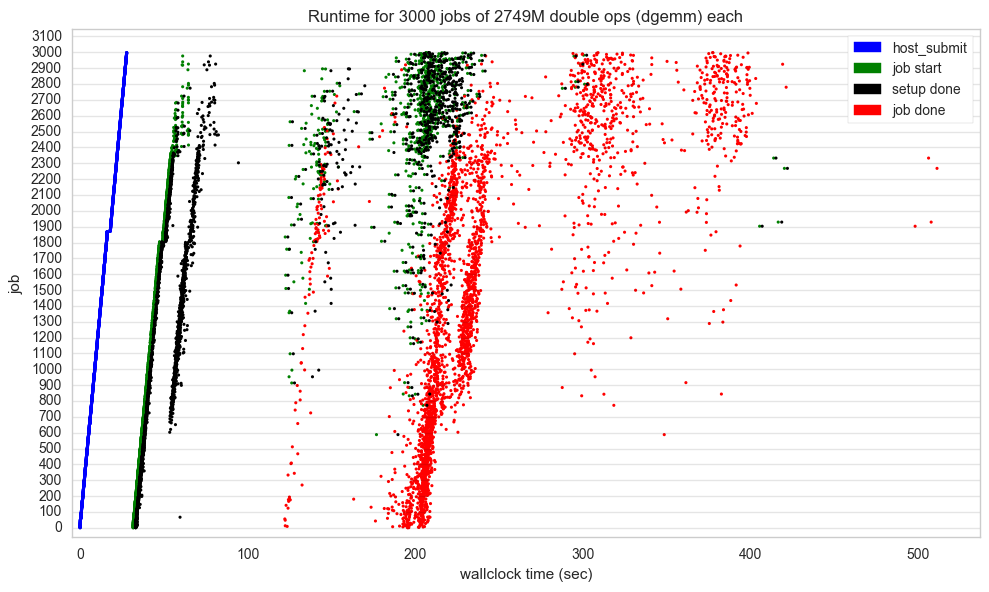

In [55]:

time_offset = np.min(results_df.host_submit_time)
fig = pylab.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
total_jobs = len(results_df)

y = np.arange(total_jobs)
point_size = 5
ax.scatter(results_df.host_submit_time - time_offset, y, c='b', edgecolor='none', s=point_size)
ax.scatter(results_df.start_time - time_offset, y, c='g', edgecolor='none', s=point_size)
ax.scatter(results_df.end_time - time_offset, y, c='r', edgecolor='none', s=point_size)
ax.scatter(results_df.start_time + results_df.setup_time - time_offset,
y, c='k', edgecolor='none', s=point_size)
ax.set_xlabel('wallclock time (sec)')
ax.set_ylabel('job')
#pylab.ylim(0, 10)

import matplotlib.patches as mpatches

host_submit_patch = mpatches.Patch(color='b', label='host_submit')
job_start_patch = mpatches.Patch(color='g', label='job start')
setup_done_patch = mpatches.Patch(color='k', label='setup done')

job_done_patch = mpatches.Patch(color='red', label='job done')

legend = pylab.legend(handles=[host_submit_patch, job_start_patch, setup_done_patch, job_done_patch, ],
                      loc='upper right', frameon=True)
pylab.title("Runtime for {} jobs of {:3.0f}M double ops (dgemm) each".format(total_jobs, JOB_GFLOPS))
legend.get_frame().set_facecolor('#FFFFFF')



plot_step = 100  #int(np.min([128, total_jobs/32]))
y_ticks = np.arange(total_jobs//plot_step + 2) * plot_step
ax.set_yticks(y_ticks)
ax.set_ylim(-0.02*total_jobs, total_jobs*1.05)

ax.set_xlim(-5, np.max(results_df.end_time - time_offset)*1.05)
for y in y_ticks:
    ax.axhline(y, c='k', alpha=0.1, linewidth=1)
 
ax.grid(False)
fig.tight_layout()
#fig.savefig("flops_benchmark.timeline.png")

In [56]:
test_index = np.arange(len(results_df.end_time))
t = np.sort(results_df.end_time) - time_offset


536.69763096570966

In [62]:
# now compute peak 
max_time = int(np.max(results_df.end_time - time_offset)*1.05)
runtime_bins = np.linspace(0, max_time, max_time)
runtime_flops_hist = np.zeros((len(results_df), len(runtime_bins)))
for i in range(len(results_df)):
    row = results_df.iloc[i]
    s = (row.start_time + row.setup_time) - time_offset
    e = row.end_time - time_offset
    a, b = np.searchsorted(runtime_bins, [s, e])
    if b-a > 0:
        runtime_flops_hist[i, a:b] = JOB_GFLOPS / float(b-a)


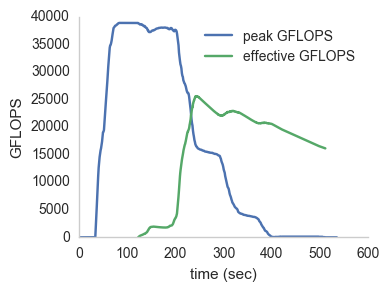

In [64]:
fig = pylab.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(runtime_flops_hist.sum(axis=0), label='peak GFLOPS')
ax.plot(t, test_index* JOB_GFLOPS/t, label='effective GFLOPS')
ax.set_xlabel('time (sec)')
ax.set_ylabel("GFLOPS")
pylab.legend()
ax.grid(False)
sns.despine()
fig.tight_layout()
fig.savefig("flops_benchmark.gflops.png")
fig.savefig("flops_benchmark.gflops.pdf")

In [60]:
runtime_flops_hist.sum(axis=0)

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         6.74047861e+01,   1.96315598e+03,   3.74943288e+03,
         5.48099306e+03,   7.49233815e+03,   9.20917855e+03,
         1.12421165e+04,   1.27636397e+04,   1.38647199e+04,
         1.46657096e+04,   1.53372092e+04,   1.58648303e+04,
         1.62743664e+04,   1.68502190e+04,   1.75037467e+04,
         1.83804327e+04,

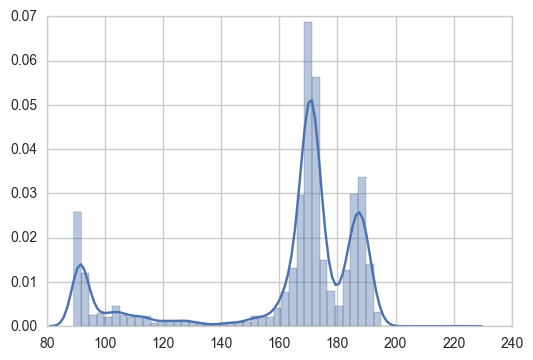

In [59]:
# job length
sns.distplot(results_df.end_time - results_df.start_time)

In [41]:
# examine runtime caching
# how many jobs on how many nodes
results_df.hw_addr.value_counts()

D2:5D:D2:60:61:84    3
62:76:86:48:4F:C5    3
EA:0F:2A:B0:65:6C    3
FE:9E:6F:4E:77:D1    3
DA:2A:B5:DE:4A:0E    3
76:1C:4E:B4:5A:1B    3
96:E5:1B:38:E8:61    3
B2:81:95:0D:CA:6C    3
AA:77:7A:4C:48:A3    2
3A:8F:3E:C9:9F:05    2
4E:9D:B5:EE:1F:9A    2
8A:49:CC:11:C9:7C    2
02:E8:86:C9:FC:DA    2
26:22:B1:AC:9F:C3    2
EE:1D:C3:58:6E:B5    2
8A:68:87:43:E9:7A    2
9E:03:54:1E:D2:49    2
D2:97:A2:42:96:5A    2
9E:FD:C9:7C:C1:E8    2
BE:1A:49:5F:57:FC    2
A2:7F:95:DD:64:F6    2
7A:94:19:76:0D:9D    2
16:55:DB:43:DB:39    2
32:76:FB:45:0D:20    2
32:AD:1B:F2:FD:46    2
2E:F8:31:F8:3F:23    2
6A:61:48:2E:E8:18    2
BE:86:96:16:05:88    2
12:AA:CD:FE:67:FF    2
1A:57:39:CC:E5:B1    2
                    ..
CA:B4:D0:D3:1E:92    1
22:4D:6F:29:B0:CE    1
EA:C9:2B:B7:3A:48    1
5E:99:03:0E:20:FF    1
06:A6:70:4C:56:04    1
0E:A0:49:22:95:42    1
E6:DE:DF:EF:2B:7B    1
D2:63:16:AA:6D:57    1
EA:AE:22:F2:19:EF    1
1A:AD:0B:F2:A7:EA    1
A6:C1:C3:D7:2B:77    1
F6:52:B4:E5:BB:CE    1
C2:1D:C4:F7

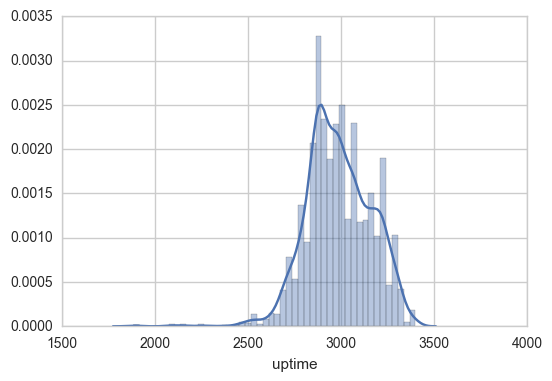

In [42]:
sns.distplot(results_df.uptime)